<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading 

**Chapter 08 &mdash; CFD Trading with Oanda**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'

## The Oanda API

`pip install v20`

In [2]:
import v20
from v20.account import Account

In [3]:
import configparser

In [4]:
config = configparser.ConfigParser()

In [5]:
config.read('../pyalgo.cfg')

['../pyalgo.cfg']

In [6]:
config.sections()

['quandl', 'eikon', 'plotly', 'oanda', 'oanda_v20', 'ibapi', 'gemini']

In [7]:
ctx = v20.Context(
            'api-fxpractice.oanda.com',
            443,
            True,
            application='sample_code',
            token=config['oanda_v20']['access_token'],
            datetime_format='RFC3339'
)

In [8]:
response = ctx.account.list()

In [9]:
accounts = response.get('accounts')

In [10]:
for account in accounts:
    print('Account: %s' %account)

Account: id: 101-004-5516121-001
tags: []


In [11]:
account_id = accounts[0].id

In [12]:
account_id

'101-004-5516121-001'

## Retrieving Historical Data

### Looking Up Instruments Available for Trading

In [13]:
response = ctx.account.instruments(config['oanda_v20']['account_id'])

In [14]:
instruments = response.get('instruments')

In [15]:
instruments[0].dict()

{'displayName': 'USD/CHF',
 'displayPrecision': 5,
 'marginRate': '0.02',
 'maximumOrderUnits': '100000000.0',
 'maximumPositionSize': '0.0',
 'maximumTrailingStopDistance': '1.0',
 'minimumTradeSize': '1.0',
 'minimumTrailingStopDistance': '0.0005',
 'name': 'USD_CHF',
 'pipLocation': -4,
 'tradeUnitsPrecision': 0,
 'type': 'CURRENCY'}

In [16]:
for instrument in instruments:
    ins = instrument.dict()
    print('%20s | %10s' % (ins['displayName'],
                           ins['name']))

             USD/CHF |    USD_CHF
        Taiwan Index |   TWIX_USD
          Silver/EUR |    XAG_EUR
          Silver/SGD |    XAG_SGD
      West Texas Oil |  WTICO_USD
        US 2Y T-Note | USB02Y_USD
             AUD/HKD |    AUD_HKD
            Gold/CAD |    XAU_CAD
       Australia 200 |  AU200_AUD
             GBP/HKD |    GBP_HKD
             EUR/DKK |    EUR_DKK
             EUR/PLN |    EUR_PLN
        Hong Kong 33 |   HK33_HKD
              UK 100 |  UK100_GBP
             GBP/CHF |    GBP_CHF
             USD/THB |    USD_THB
                Bund | DE10YB_EUR
             USD/SEK |    USD_SEK
             GBP/SGD |    GBP_SGD
             USD/INR |    USD_INR
         UK 10Y Gilt | UK10YB_GBP
             AUD/CHF |    AUD_CHF
             EUR/SGD |    EUR_SGD
          US SPX 500 | SPX500_USD
            Gold/GBP |    XAU_GBP
             CAD/SGD |    CAD_SGD
           France 40 |   FR40_EUR
          Silver/CHF |    XAG_CHF
             EUR/AUD |    EUR_AUD
       US Wall

### Backtesting a Momentum Strategy on Minute Bars

In [17]:
import datetime as dt

In [18]:
suffix = '.000000000Z'

In [19]:
fromTime = dt.datetime(2016, 12, 8, 8, 0, 0)

In [20]:
fromTime = fromTime.isoformat('T') + suffix

In [21]:
fromTime

'2016-12-08T08:00:00.000000000Z'

In [22]:
toTime = dt.datetime(2016, 12, 10, 8, 0, 0)

In [23]:
toTime = toTime.isoformat('T') + suffix

In [24]:
%%time
res = ctx.instrument.candles(instrument='EUR_USD',
                             fromTime=fromTime,
                             toTime=toTime,
                             granularity='M1',
                             price='A')

CPU times: user 65 ms, sys: 10.4 ms, total: 75.5 ms
Wall time: 3.74 s


In [25]:
import pandas as pd

In [26]:
raw = res.get('candles')

In [27]:
raw = [cs.dict() for cs in raw]

In [28]:
for cs in raw:
    cs.update(cs['ask'])
    del cs['ask']

In [29]:
raw[0]

{'c': '1.07651',
 'complete': True,
 'h': '1.07655',
 'l': '1.07625',
 'o': '1.0765',
 'time': '1481184000.000000000',
 'volume': 68}

In [30]:
data = pd.DataFrame(raw)

In [31]:
data['time']= pd.to_datetime(data['time'], unit='s')

In [32]:
data = data.set_index('time')

In [33]:
data.index = pd.DatetimeIndex(data.index)

In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2208 entries, 2016-12-08 08:00:00 to 2016-12-09 21:59:00
Data columns (total 6 columns):
c           2208 non-null object
complete    2208 non-null bool
h           2208 non-null object
l           2208 non-null object
o           2208 non-null object
volume      2208 non-null int64
dtypes: bool(1), int64(1), object(4)
memory usage: 105.7+ KB


In [35]:
data[['c', 'l', 'h', 'o']] = data[
                ['c', 'l', 'h', 'o']].astype('float64')

In [36]:
data = data.rename(columns={'c':'closeAsk', 'l':'lowAsk',
                            'h':'highAsk', 'o':'openAsk' })

In [37]:
data[['closeAsk', 'volume']].head()

,closeAsk,volume
time,,
2016-12-08 08:00:00,1.07651,68
2016-12-08 08:01:00,1.07626,37
2016-12-08 08:02:00,1.07638,28
2016-12-08 08:03:00,1.07641,17
2016-12-08 08:04:00,1.07649,16


In [38]:
import numpy as np

In [39]:
data['returns'] = np.log(data['closeAsk'] / data['closeAsk'].shift(1))

In [40]:
cols = []

In [41]:
for momentum in [15, 30, 60, 120]:
    col = 'position_%s' % momentum
    data[col] = np.sign(data['returns'].rolling(momentum).mean())
    cols.append(col)

In [42]:
strats = ['returns']

In [43]:
for col in cols:
    strat = 'strategy_%s' % col.split('_')[1]
    data[strat] = data[col].shift(1) * data['returns']
    strats.append(strat)

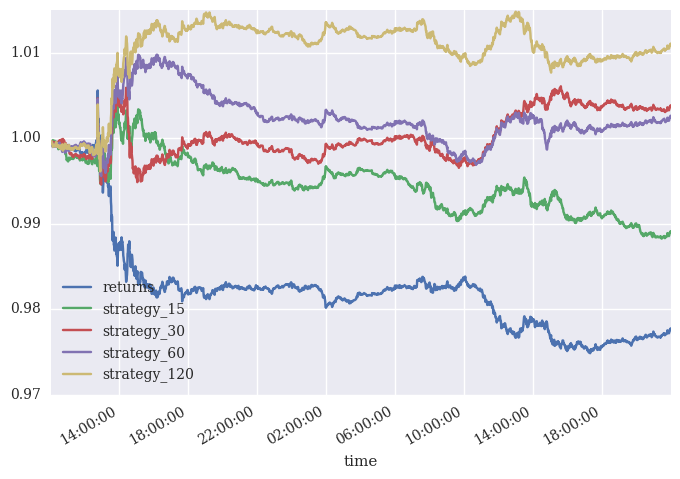

In [44]:
data[strats].dropna().cumsum().apply(np.exp).plot()
plt.savefig('../../images/ch08/oanda_plot_1.png')

### Factoring In Leverage and Margin

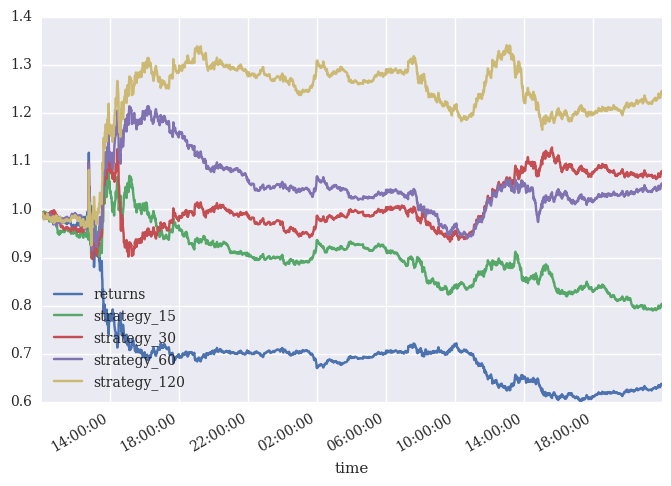

In [45]:
data[strats].dropna().cumsum().apply(
            lambda x: x * 20).apply(np.exp).plot()
plt.savefig('../../images/ch08/oanda_plot_2.png')

## Working with Streaming Data

In [46]:
ctx_stream = v20.Context(
            'stream-fxpractice.oanda.com',
            443,
            True,
            application='sample_code',
            token=config['oanda_v20']['access_token'],
            datetime_format='RFC3339')

In [47]:
response = ctx_stream.pricing.stream(
            account_id,
            snapshot=True,
            instruments='EUR_USD')

In [48]:
i = 0
for msg_type, msg in response.parts():
    if msg_type == 'pricing.Price':
        i += 1
        output = '%s (%s) %s/%s' % (msg.instrument, msg.time,
                                   msg.bids[0].price, msg.asks[0].price)
        print(output)
    if i == 10:
        break

EUR_USD (2017-03-15T09:48:09.869389684Z) 1.06244/1.06256
EUR_USD (2017-03-15T09:48:10.916938638Z) 1.06246/1.06258
EUR_USD (2017-03-15T09:48:12.571429947Z) 1.06247/1.06258
EUR_USD (2017-03-15T09:48:14.431331876Z) 1.06249/1.0626
EUR_USD (2017-03-15T09:48:17.447462084Z) 1.06251/1.06263
EUR_USD (2017-03-15T09:48:19.161625069Z) 1.06256/1.06267
EUR_USD (2017-03-15T09:48:21.168117151Z) 1.06256/1.06268
EUR_USD (2017-03-15T09:48:21.591412130Z) 1.06251/1.06263
EUR_USD (2017-03-15T09:48:26.345683526Z) 1.06247/1.06259
EUR_USD (2017-03-15T09:48:42.784846269Z) 1.06243/1.06254


## Placing Orders

In [49]:
request = ctx.order.market(account_id, instrument='EUR_USD', units=10)
order = request.get('orderFillTransaction')

In [50]:
order.summary()

'Fill Order 487 (MARKET_ORDER): 10.0 of EUR_USD @ 1.06254'

In [51]:
request = ctx.order.market(account_id, instrument='EUR_USD', units=-10)
order = request.get('orderFillTransaction')

In [52]:
order.summary()

'Fill Order 489 (MARKET_ORDER): -10.0 of EUR_USD @ 1.06243'

## Implementing Trading Strategies in Real-Time

In [53]:
import MomentumTrader_v20_sn as MT

In [54]:
from importlib import reload

In [55]:
reload(MT)

<module 'MomentumTrader_v20_sn' from '/Users/yves/Dropbox/Platform/pyalgo/code/ch08/MomentumTrader_v20_sn.py'>

In [56]:
mt = MT.MomentumTrader(momentum=6, instrument='EUR_USD',
                       units=50000)
mt.start()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 

 {'pl': '0.0', 'instrument': 'EUR_USD', 'units': '-50000.0', 'tradeOpened': {'units': '-50000.0', 'tradeID': '492'}, 'type': 'ORDER_FILL', 'userID': 5516121, 'financing': '0.0', 'id': '492', 'accountBalance': '98606.3044', 'orderID': '491', 'batchID': '491', 'price': '1.06241', 'reason': 'MARKET_ORDER', 'accountID': '101-004-5516121-001', 'time': '2017-03-15T09:54:05.007932319Z'} 

134 135 136 137 

 {'pl': '-7.5298', 'instrument': 'EUR_USD', 'units': '100000.0', 'tradeOpened': {'units': '50000.0', 'tradeID': '494'}, 'type': 'ORDER_FILL', 'userID': 5516121, 'financing

'Finished.'

### Retrieving Account Information

In [57]:
response = ctx.account.summary(account_id)

In [58]:
acc_summary = response.get('account')

In [59]:
acc_summary.dict()

{'NAV': '98599.2235',
 'alias': 'Primary',
 'balance': '98599.2235',
 'createdByUserID': 5516121,
 'createdTime': '2017-03-08T16:28:21.276100637Z',
 'currency': 'EUR',
 'hedgingEnabled': False,
 'id': '101-004-5516121-001',
 'lastTransactionID': '504',
 'marginAvailable': '98599.2235',
 'marginCallMarginUsed': '0.0',
 'marginCallPercent': '0.0',
 'marginCloseoutMarginUsed': '0.0',
 'marginCloseoutNAV': '98599.2235',
 'marginCloseoutPercent': '0.0',
 'marginCloseoutUnrealizedPL': '0.0',
 'marginRate': '0.02',
 'marginUsed': '0.0',
 'openPositionCount': 0,
 'openTradeCount': 0,
 'pendingOrderCount': 0,
 'pl': '-1400.4954',
 'positionValue': '0.0',
 'unrealizedPL': '0.0',
 'withdrawalLimit': '98599.2235'}

In [60]:
response = ctx.account.get(account_id)

In [61]:
acc_full = response.get('account')

In [62]:
acc_full.dict()

{'NAV': '98599.2235',
 'alias': 'Primary',
 'balance': '98599.2235',
 'createdByUserID': 5516121,
 'createdTime': '2017-03-08T16:28:21.276100637Z',
 'currency': 'EUR',
 'hedgingEnabled': False,
 'id': '101-004-5516121-001',
 'lastTransactionID': '504',
 'marginAvailable': '98599.2235',
 'marginCallMarginUsed': '0.0',
 'marginCallPercent': '0.0',
 'marginCloseoutMarginUsed': '0.0',
 'marginCloseoutNAV': '98599.2235',
 'marginCloseoutPercent': '0.0',
 'marginCloseoutUnrealizedPL': '0.0',
 'marginRate': '0.02',
 'marginUsed': '0.0',
 'openPositionCount': 0,
 'openTradeCount': 0,
 'orders': [],
 'pendingOrderCount': 0,
 'pl': '-1400.4954',
 'positionValue': '0.0',
 'positions': [{'instrument': 'EUR_USD',
   'long': {'pl': '-311.4343',
    'resettablePL': '-311.4343',
    'units': '0.0',
    'unrealizedPL': '0.0'},
   'pl': '-556.4954',
   'resettablePL': '-556.4954',
   'short': {'pl': '-245.0611',
    'resettablePL': '-245.0611',
    'units': '0.0',
    'unrealizedPL': '0.0'},
   'unreali

In [73]:
response = ctx.transaction.since(account_id, id=497)

In [74]:
transactions = response.get('transactions')

In [75]:
for transaction in transactions:
    print('\n', transaction.dict())


 {'pl': '-3.7651', 'instrument': 'EUR_USD', 'units': '100000.0', 'tradeOpened': {'units': '50000.0', 'tradeID': '498'}, 'type': 'ORDER_FILL', 'userID': 5516121, 'financing': '0.0', 'id': '498', 'accountBalance': '98587.9497', 'orderID': '497', 'batchID': '497', 'price': '1.0625', 'reason': 'MARKET_ORDER', 'accountID': '101-004-5516121-001', 'time': '2017-03-15T09:55:00.232549066Z', 'tradesClosed': [{'financing': '0.0', 'units': '50000.0', 'realizedPL': '-3.7651', 'tradeID': '496'}]}

 {'userID': 5516121, 'units': '-100000.0', 'timeInForce': 'FOK', 'positionFill': 'DEFAULT', 'type': 'MARKET_ORDER', 'batchID': '499', 'accountID': '101-004-5516121-001', 'id': '499', 'reason': 'CLIENT_ORDER', 'instrument': 'EUR_USD', 'time': '2017-03-15T09:55:09.045056353Z'}

 {'pl': '-9.4135', 'instrument': 'EUR_USD', 'units': '-100000.0', 'tradeOpened': {'units': '-50000.0', 'tradeID': '500'}, 'type': 'ORDER_FILL', 'userID': 5516121, 'financing': '-0.0001', 'id': '500', 'accountBalance': '98578.5361', '

In [72]:
for trans in transactions:
    trans = trans.dict()
    templ = '%s | %14s | %12s'
    print(templ % (trans['time'],
                   trans['instrument'],
                   trans['units']))

2017-03-15T09:54:52.780004165Z |        EUR_USD |    -100000.0
2017-03-15T09:55:00.232549066Z |        EUR_USD |     100000.0
2017-03-15T09:55:00.232549066Z |        EUR_USD |     100000.0
2017-03-15T09:55:09.045056353Z |        EUR_USD |    -100000.0
2017-03-15T09:55:09.045056353Z |        EUR_USD |    -100000.0
2017-03-15T09:55:11.251494245Z |        EUR_USD |     100000.0
2017-03-15T09:55:11.251494245Z |        EUR_USD |     100000.0
2017-03-15T09:59:16.758814672Z |        EUR_USD |     -50000.0
2017-03-15T09:59:16.758814672Z |        EUR_USD |     -50000.0


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>

**Python Quant Platform** |
<a href="http://quant-platform.com">http://quant-platform.com</a>

**Python for Finance** |
<a href="http://python-for-finance.com" target="_blank">Python for Finance @ O'Reilly</a>

**Derivatives Analytics with Python** |
<a href="http://derivatives-analytics-with-python.com" target="_blank">Derivatives Analytics @ Wiley Finance</a>

**Listed Volatility and Variance Derivatives** |
<a href="http://lvvd.tpq.io" target="_blank">Listed VV Derivatives @ Wiley Finance</a>

**Python Training** |
<a href="http://training.tpq.io" target="_blank">Python for Finance University Certificate</a>